Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

# Installation
To be able to run the animation below, make sure you have the latest version of matplotlib, by running `python3 -m pip install matplotlib --upgrade`

In [0]:
%matplotlib inline
import json
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D, MaxPooling1D, Conv2D, Conv1D
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

## Define the game environment and replay classes
The idea in this Catch game is that there is fruit falling, and the user gets to move a basket so that they catch the fruit. If they catch it, they win and the game is over. If they miss it, they lose and the game is over. We are trying to teach the computer to play this game.

In [0]:
class Catch(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_basket_center = 1
        self.max_basket_center = self.grid_size-2
        self.reset()
        self.fruits_caught = 0 
        self.best_score = 1

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves basket according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, basket_center = self.state
        # move the basket unless this would move it off the edge of the grid
        new_basket_center = min(max(self.min_basket_center, basket_center + movement), self.max_basket_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_basket_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and basket and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, basket_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, basket_center-1:basket_center + 2] = 1  # draw 3-pixel basket
        return canvas
    #     Code for Exercise 3
    # def _get_reward(self):
    
    #     '''
    #     Returns 1 if the fruit was caught, -1 if it was dropped, and 0 if it is still in the air.
    #     '''
    #     fruit_x, fruit_y, basket_center = self.state
    #     if fruit_y == self.grid_size-1:
    #         if abs(fruit_x - basket_center) <= 1:
    #             return -1 # it caught the fruit
    #         else:
    #             return 1 # it dropped the fruit
    #     else:
    #         return 0 # the fruit is still in the air
    def _get_reward(self):
        '''
        Returns 1 if the fruit was caught, -1 if it was dropped, and 0 if it is still in the air.
        '''
        #code for exercise 4
        fruit_x, fruit_y, basket_center = self.state
        best_score = self.best_score
        if fruit_y == self.grid_size-1:
            fruits_caught = self.fruits_caught
            if abs(fruit_x - basket_center) <= 1:
                self.fruits_caught += 1
                if (fruits_caught >= 20):
                    self.fruits_caught = 0
                    self.best_score = fruits_caught
                    return 1
                self.reset()
                return 0 #game should keep going
            else:
                self.fruits_caught = 0
                self.best_score = fruits_caught
                #Adjusting reward slightly so 0 doesn't get returned
                if fruits_caught == best_score-1:
                    return -0.01
                return max(-1, (fruits_caught+1 - best_score) / 2)
                #return -1 # it dropped the fruit
        else:
            return 0 # the fruit is still in the air
    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if game is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        game_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, game_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            basket center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        basket_center = random.randint(self.min_basket_center, self.max_basket_center)
        self.state = np.asarray([fruit_x, fruit_y, basket_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            game_over: boolean
        Add the states and game over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            game_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            #convolutional
            #targets[i] = model.predict(starting_observation.reshape(-1,10,10,1))[0]
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if game_over: 
                # if the game is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the game is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                #convolutional
                #Q_sa = np.max(model.predict(new_observation.reshape(-1,10,10,1))[0])
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




##  Functions for creating, training, and visualizing the model

In [0]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10
print_freq = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    # Convolutional Model for exercise #2
    # The model was very bad before I changed the optimizer
    
    # model.add(Conv2D(input_shape=(grid_size, grid_size, 1),
    #              filters=32, kernel_size=5, strides=1, padding='same', activation='tanh'))
    # model.add(Conv2D(input_shape=(grid_size, grid_size, 1),
    #              filters=32, kernel_size=5, strides=1, padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.15))
    # model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='tanh'))
    # model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
    # model.add(Flatten())
    # model.add(Dense(units=32, activation='relu'))
    # model.add(Dense(units=num_actions, activation='relu'))
    # model.add(RMSprop(), "mse")
    model.compile(Adam(), "mse")

    # Define environment/game
    env = Catch(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay

def take_step(exp_replay, model, starting_observation):
    # get next action
    if np.random.rand() <= epsilon:
        # epsilon of the time, we just choose randomly
        action = np.random.randint(0, num_actions, size=1)
    else:
        # find which action the model currently thinks is best from this state
        #convolutional
        #q = model.predict(starting_observation.reshape(-1,10,10,1))
        q = model.predict(starting_observation)
        action = np.argmax(q[0])

    # apply action, get rewards and new state
    new_observation, reward, game_over = env.act(action)

    # store experience
    exp_replay.remember([starting_observation, action, reward, new_observation], game_over)

    return new_observation, reward, game_over
    

def train_model(model, env, exp_replay, num_episodes, pretrain_episodes=100):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(pretrain_episodes):
        env.reset()
        game_over = False
        # get initial input
        starting_observation = env.observe()

        while not game_over:
            starting_observation, reward, game_over = \
                take_step(exp_replay, model, starting_observation)
    last_total_reward = 0
    total_reward = 0
    for episode in range(1, num_episodes+1):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        starting_observation = env.observe()

        while not game_over:
            starting_observation, reward, game_over = \
                take_step(exp_replay, model, starting_observation)
            total_reward += reward
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        #convolutional
        #loss += model.train_on_batch(inputs.reshape(-1,10,10,1), targets)          
        loss += model.train_on_batch(inputs, targets)  

        # Print update from this episode
        if episode % print_freq == 0:
            print("Episodes {:04d}-{:04d}/{:04d} | Loss {:.4f} | Total Reward {} | Change in Reward {}".format(
                episode - print_freq + 1, episode, num_episodes, loss, total_reward, total_reward - last_total_reward))
            last_total_reward = total_reward
            total_reward = 0



def create_animation(model, env, num_games):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_games: integer, the number of games to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the games and collect all of the images for each observed state
    observations = []
    total_reward = 0
    #for _ in range(1):
    for _ in range(num_games):
        env.reset()
        observation = env.observe()
        observations.append(observation)
        game_over = False
        while game_over == False:
            #observation needs to be reshaped for convolutional layer
            #q = model.predict(observation.reshape(-1,10,10,1))
            #normal
            q = model.predict([observation])
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, game_over = env.act(action)
            observations.append(observation)
            total_reward += reward
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    print('Total Reward: {}'.format(total_reward))
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Let's create our model and game environment and see how it does before training

In [0]:
model, env, exp_replay = build_model()

In [0]:
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

## Now train the model and see how much better it is at catching the fruit

Episodes 0001-0010/1000 | Loss 0.0324 | Total Reward -8 | Change in Reward -8
Episodes 0011-0020/1000 | Loss 0.0301 | Total Reward 0 | Change in Reward 8
Episodes 0021-0030/1000 | Loss 0.0101 | Total Reward -4 | Change in Reward -4
Episodes 0031-0040/1000 | Loss 0.0241 | Total Reward -2 | Change in Reward 2
Episodes 0041-0050/1000 | Loss 0.0512 | Total Reward -4 | Change in Reward -2
Episodes 0051-0060/1000 | Loss 0.0222 | Total Reward -4 | Change in Reward 0
Episodes 0061-0070/1000 | Loss 0.0238 | Total Reward 0 | Change in Reward 4
Episodes 0071-0080/1000 | Loss 0.0171 | Total Reward -4 | Change in Reward -4
Episodes 0081-0090/1000 | Loss 0.0273 | Total Reward 0 | Change in Reward 4
Episodes 0091-0100/1000 | Loss 0.0251 | Total Reward -10 | Change in Reward -10
Episodes 0101-0110/1000 | Loss 0.0161 | Total Reward -4 | Change in Reward 6
Episodes 0111-0120/1000 | Loss 0.0089 | Total Reward -4 | Change in Reward 0
Episodes 0121-0130/1000 | Loss 0.0146 | Total Reward -2 | Change in Rewa

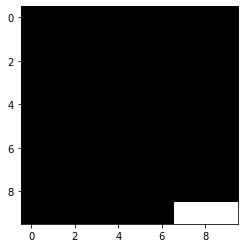

In [0]:
#Original network
train_model(model, env, exp_replay, num_episodes=1000)
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

# Possible Exercises:
1. Add a validation function, to make it easier to assess models.
1. We've been looking at convolutional neural networks for image processing. Try changing the model to use convolutional layers. Does this seem to work any better?
1. Change the code so that the basket is trying to avoid getting hit by the fruit.
1. Change the code so the game keeps going until the basket misses the fruit. (To test that this is working, you may want to change the number of games in the animation to 1.) How should this change the rewards that the model gets?
1. Change the game to something entirely different.
1. Try changing how the training works (for instance, changing the discount rate or having the model always choose the action randomly weighted by the action values). Keep notes on what you observe as to how this changes the model performance.

Using RMSprop, the convolutional layers made the model train much faster. However, when using ADAM, the convolutional layers could not train.

In [0]:
model, env, exp_replay = build_model()

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 10, 10, 32)        832       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 32)        25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 5, 5, 64)          18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 5, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)             

Total Reward: -6


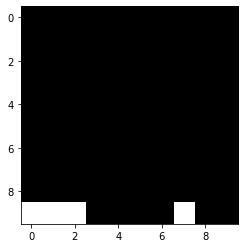

In [0]:
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

Episodes 0001-0010/1000 | Loss 0.0531 | Total Reward 0 | Change in Reward 0
Episodes 0011-0020/1000 | Loss 0.0397 | Total Reward -2 | Change in Reward -2
Episodes 0021-0030/1000 | Loss 0.0341 | Total Reward -2 | Change in Reward 0
Episodes 0031-0040/1000 | Loss 0.0282 | Total Reward -4 | Change in Reward -2
Episodes 0041-0050/1000 | Loss 0.0282 | Total Reward 2 | Change in Reward 6
Episodes 0051-0060/1000 | Loss 0.0078 | Total Reward 6 | Change in Reward 4
Episodes 0061-0070/1000 | Loss 0.0374 | Total Reward 8 | Change in Reward 2
Episodes 0071-0080/1000 | Loss 0.0090 | Total Reward 4 | Change in Reward -4
Episodes 0081-0090/1000 | Loss 0.0152 | Total Reward 2 | Change in Reward -2
Episodes 0091-0100/1000 | Loss 0.0137 | Total Reward -4 | Change in Reward -6
Episodes 0101-0110/1000 | Loss 0.0644 | Total Reward 6 | Change in Reward 10
Episodes 0111-0120/1000 | Loss 0.0212 | Total Reward 6 | Change in Reward 0
Episodes 0121-0130/1000 | Loss 0.0438 | Total Reward 0 | Change in Reward -6
E

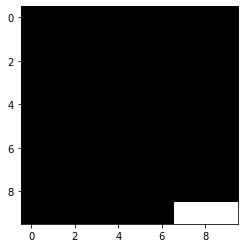

In [0]:
#convolutional network
train_model(model, env, exp_replay, num_episodes=1000)
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

3.

In [0]:
#Avoiding the fruit
#Interestingly enough, the dense neural network seemed to work better for this 
#than the convolutional network
model_drop, env, exp_replay = build_model()
model_drop.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 20,503
Trainable params: 20,503
Non-trainable params: 0
_________________________________________________________________


Total Reward: 2


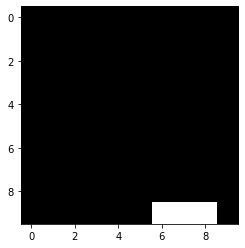

In [0]:
animation = create_animation(model_drop, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

Episodes 0001-0010/1000 | Loss 0.0386 | Total Reward 2 | Change in Reward 2
Episodes 0011-0020/1000 | Loss 0.0298 | Total Reward 6 | Change in Reward 4
Episodes 0021-0030/1000 | Loss 0.0244 | Total Reward 4 | Change in Reward -2
Episodes 0031-0040/1000 | Loss 0.0376 | Total Reward 6 | Change in Reward 2
Episodes 0041-0050/1000 | Loss 0.0209 | Total Reward 2 | Change in Reward -4
Episodes 0051-0060/1000 | Loss 0.0169 | Total Reward 2 | Change in Reward 0
Episodes 0061-0070/1000 | Loss 0.0166 | Total Reward 8 | Change in Reward 6
Episodes 0071-0080/1000 | Loss 0.0254 | Total Reward 4 | Change in Reward -4
Episodes 0081-0090/1000 | Loss 0.0371 | Total Reward 2 | Change in Reward -2
Episodes 0091-0100/1000 | Loss 0.0082 | Total Reward 2 | Change in Reward 0
Episodes 0101-0110/1000 | Loss 0.0105 | Total Reward 2 | Change in Reward 0
Episodes 0111-0120/1000 | Loss 0.0677 | Total Reward 0 | Change in Reward -2
Episodes 0121-0130/1000 | Loss 0.0371 | Total Reward 2 | Change in Reward 2
Episode

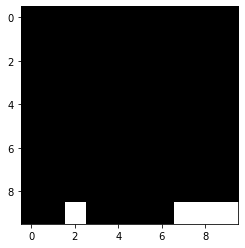

In [0]:
train_model(model_drop, env, exp_replay, num_episodes=1000)
animation = create_animation(model_drop, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

In [4]:
#Game doesn't end until fruit drops
model_drop, env, exp_replay = build_model()
model_drop.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 20,503
Trainable params: 20,503
Non-trainable params: 0
_________________________________________________________________


Total Reward: -0.01


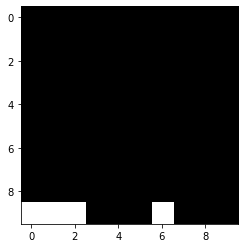

In [5]:
animation = create_animation(model_drop, env, num_games=1)
IPython.display.HTML(animation.to_jshtml())

Episodes 0001-0010/0750 | Loss 0.0041 | Total Reward 5.0 | Change in Reward 5.0
Episodes 0011-0020/0750 | Loss 0.0275 | Total Reward 4.99 | Change in Reward -0.009999999999999787
Episodes 0021-0030/0750 | Loss 0.0014 | Total Reward 5.0 | Change in Reward 0.009999999999999787
Episodes 0031-0040/0750 | Loss 0.0084 | Total Reward 4.98 | Change in Reward -0.019999999999999574
Episodes 0041-0050/0750 | Loss 0.0035 | Total Reward 4.99 | Change in Reward 0.009999999999999787
Episodes 0051-0060/0750 | Loss 0.0015 | Total Reward 4.970000000000001 | Change in Reward -0.019999999999999574
Episodes 0061-0070/0750 | Loss 0.0159 | Total Reward 5.99 | Change in Reward 1.0199999999999996
Episodes 0071-0080/0750 | Loss 0.0257 | Total Reward 5.49 | Change in Reward -0.5
Episodes 0081-0090/0750 | Loss 0.0074 | Total Reward 3.9800000000000004 | Change in Reward -1.5099999999999998
Episodes 0091-0100/0750 | Loss 0.0110 | Total Reward 5.49 | Change in Reward 1.5099999999999998
Episodes 0101-0110/0750 | Loss

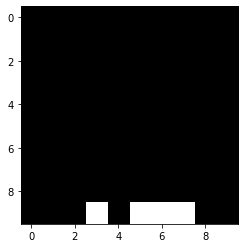

In [6]:
#I need better validation for this approach
#Needs improvement in the future, I can't even tell how many times the fruit gets caught

train_model(model_drop, env, exp_replay, num_episodes=750)
animation = create_animation(model_drop, env, num_games=1)
IPython.display.HTML(animation.to_jshtml())